# Sound Spectrogram Display with Different F0 Predictors

Loading yutian.mp3
Calculating f0
dio done!
harvest done!
pm done!
rmvpe done!
crepe done!
Calculating spectrogram


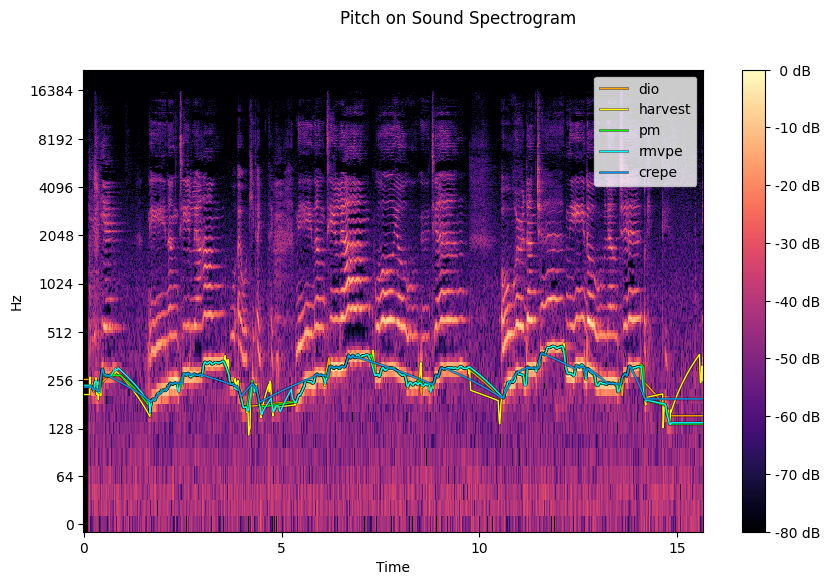

In [4]:
import argparse

# parser = argparse.ArgumentParser(prog="f0_view", description="Compares the results of various f0 methods")
# parser.add_argument("filename")
# args = parser.parse_args()

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

import librosa
import librosa.display

import utils

f0_methods = ["dio", "harvest", "pm", "rmvpe", "crepe"]
colors = ["orange", "yellow", "lime", "cyan", "xkcd:azure"]

filename = "yutian.mp3"
print(f"Loading {filename}")
y, sr = librosa.load(filename, sr=44100, mono=True)

print(f"Calculating f0")
results = []

hop_length = 512 # Default hop_length in config
for method, color in zip(f0_methods, colors):
    f0_predictor_object = utils.get_f0_predictor(method, hop_length=hop_length,sampling_rate=sr,device="cpu",threshold=0.05)
    f0, _ = f0_predictor_object.compute_f0_uv(y)
    # f0 = so_vits_svc_fork.f0.compute_f0(y, sampling_rate=sr, hop_length=hop_length, method=method)
    f0[f0 <= 1e-05] = float("nan")
    times = librosa.times_like(f0, sr=sr, hop_length=hop_length)
    results.append((times, f0, method, color))
    print(f"{method} done!")
torch.cuda.empty_cache()

print("Calculating spectrogram")
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

fig, ax = plt.subplots(figsize=(10, 6))
img = librosa.display.specshow(S_db, x_axis="time", y_axis="log", sr=sr, ax=ax)
fig.colorbar(img, ax=ax, format="%2.f dB")

lines = []
for times, f0, label, color in results:
    line = ax.plot(times, f0, label=label, color=color, linewidth=1, path_effects=[pe.Stroke(linewidth=2, foreground="black", alpha=0.5), pe.Normal()])
    lines.append(line)

leg = ax.legend(loc='upper right')
lined = {}
for legline, plotline in zip(leg.get_lines(), lines):
    legline.set_picker(True)
    lined[legline] = plotline[0]

def on_pick(event):
    legline = event.artist
    plotline = lined[legline]
    visible = not plotline.get_visible()
    plotline.set_visible(visible)
    legline.set_alpha(1.0 if visible else 0.2)
    fig.canvas.draw()

fig.canvas.mpl_connect('pick_event', on_pick)

fig.suptitle("Pitch on Sound Spectrogram")

plt.show()


# Mel Spectrogram Display with Different F0 Predictors

Got mel spectrogram with shape torch.Size([1, 128, 1348])
dio done with shape (1348,)
harvest done with shape (1348,)
pm done with shape (1348,)
rmvpe done with shape (1348,)
crepe done with shape (1348,)


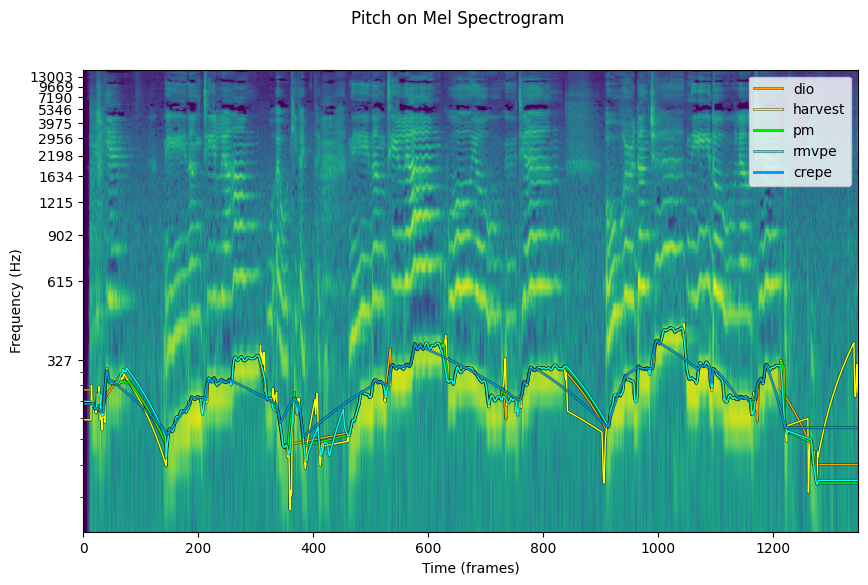

In [5]:
import librosa
import numpy as np
import torch
from librosa.core import hz_to_mel, mel_frequencies
# from loguru import logger
from matplotlib import pyplot as plt
import matplotlib.patheffects as pe

import utils
from vdecoder.nsf_hifigan.nvSTFT import STFT


f0_methods = ["dio", "harvest", "pm", "rmvpe", "crepe"]
colors = ["orange", "yellow", "lime", "cyan", "xkcd:azure"]

device = "cuda" if torch.cuda.is_available() else "cpu"

f_min = 40
f_max = 16000
n_mels = 128
sr = 44100
n_fft = 2048

min_mel = hz_to_mel(f_min)
max_mel = hz_to_mel(f_max)
f_to_mel = lambda x: (hz_to_mel(x) - min_mel) / (max_mel - min_mel) * n_mels
mel_freqs = mel_frequencies(n_mels=n_mels, fmin=f_min, fmax=f_max)

y, sr = librosa.load(
    "yutian.mp3",
    sr=sr,
    mono=True,
)
audio = torch.from_numpy(y).unsqueeze(0).to(device)


stft = STFT(
    sr, 
    n_mels, 
    n_fft,
    2048, 
    512, 
    f_min, 
    f_max)
mel = stft.get_mel(audio)
# mel = (
#     get_mel_from_audio(audio, sr, f_min=f_min, f_max=f_max, n_mels=n_mels).cpu().numpy()
# )
print(f"Got mel spectrogram with shape {mel.shape}")

results = []
hop_length = 512
for method, color in zip(f0_methods, colors):
    f0_predictor_object = utils.get_f0_predictor(method, hop_length=hop_length,sampling_rate=sr,device="cpu",threshold=0.05)
    f0, _ = f0_predictor_object.compute_f0_uv(y)
    # f0 = so_vits_svc_fork.f0.compute_f0(y, sampling_rate=sr, hop_length=hop_length, method=method)
    f0 = f_to_mel(f0)
    f0[f0 <= 1e-05] = float("nan")
    times = librosa.times_like(f0, sr=sr, hop_length=hop_length)
    results.append((times, f0, method, color))
    print(f"{method} done with shape {f0.shape}")
torch.cuda.empty_cache()


fig, ax = plt.subplots(figsize=(10, 6))
# img = librosa.display.specshow(mel_np[0], x_axis="time", y_axis="log", sr=sr, ax=ax)

ax.imshow(mel[0, :, :], aspect="auto", origin="lower")

# Try
ax.set_yscale('log')

ax.set_yticks(np.arange(0, n_mels, 10))
ax.set_yticklabels(np.round(mel_freqs[::10]).astype(int))

ax.set_ylabel("Frequency (Hz)")
ax.set_xlabel("Time (frames)")
ax.legend()

# fig.colorbar(img, ax=ax, format="%2.f dB")


# Overlay f0
lines = []
for times, f0, label, color in results:
    line = ax.plot(f0, label=label, color=color, linewidth=1, path_effects=[pe.Stroke(linewidth=2, foreground="black", alpha=0.5), pe.Normal()])
    # line = ax.plot(times, f0, label=label, color=color, linewidth=1, path_effects=[pe.Stroke(linewidth=2, foreground="black", alpha=0.5), pe.Normal()])
    lines.append(line)


leg = ax.legend(loc='upper right')
lined = {}
for legline, plotline in zip(leg.get_lines(), lines):
    legline.set_picker(True)
    lined[legline] = plotline[0]

def on_pick(event):
    legline = event.artist
    plotline = lined[legline]
    visible = not plotline.get_visible()
    plotline.set_visible(visible)
    legline.set_alpha(1.0 if visible else 0.2)
    fig.canvas.draw()

fig.canvas.mpl_connect('pick_event', on_pick)

fig.suptitle("Pitch on Mel Spectrogram")

plt.show()
